In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, roc_curve,f1_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
#import category_encoders as ce 
import numpy as np
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import catboost

In [3]:
df_train = pd.read_csv('https://raw.githubusercontent.com/DrIanGregory/Kaggle-GiveMeSomeCredit/master/data/GiveMeSomeCredit-training.csv')
print(df_train.shape)

(101503, 12) (150000, 12)


Загружаем датасет, его не нужно скачивать, он автоматически подгружается с гитхаба.

In [4]:
df_train

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [5]:
df_train = df_train.drop(columns='Unnamed: 0')
df_train.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


In [6]:
df_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [7]:
df_train['SeriousDlqin2yrs'].value_counts()


0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

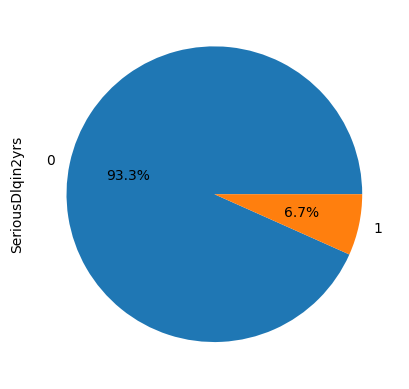

In [8]:
df_train['SeriousDlqin2yrs'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

Процент людей, которые не расплатились: 0.06684


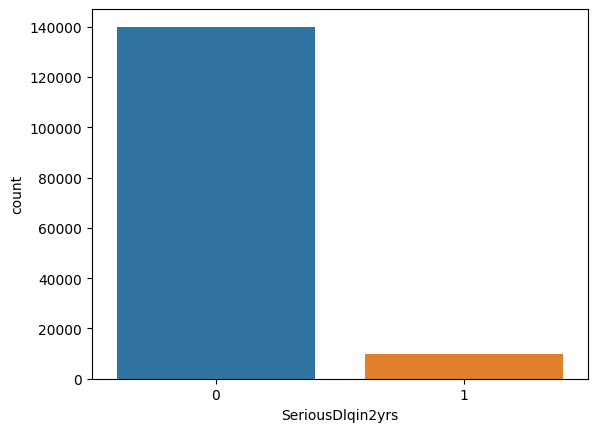

In [9]:
sns.countplot(x="SeriousDlqin2yrs", data=df_train)
print(f"Процент людей, которые не расплатились: {(df_train['SeriousDlqin2yrs'].sum() / len(df_train))}")

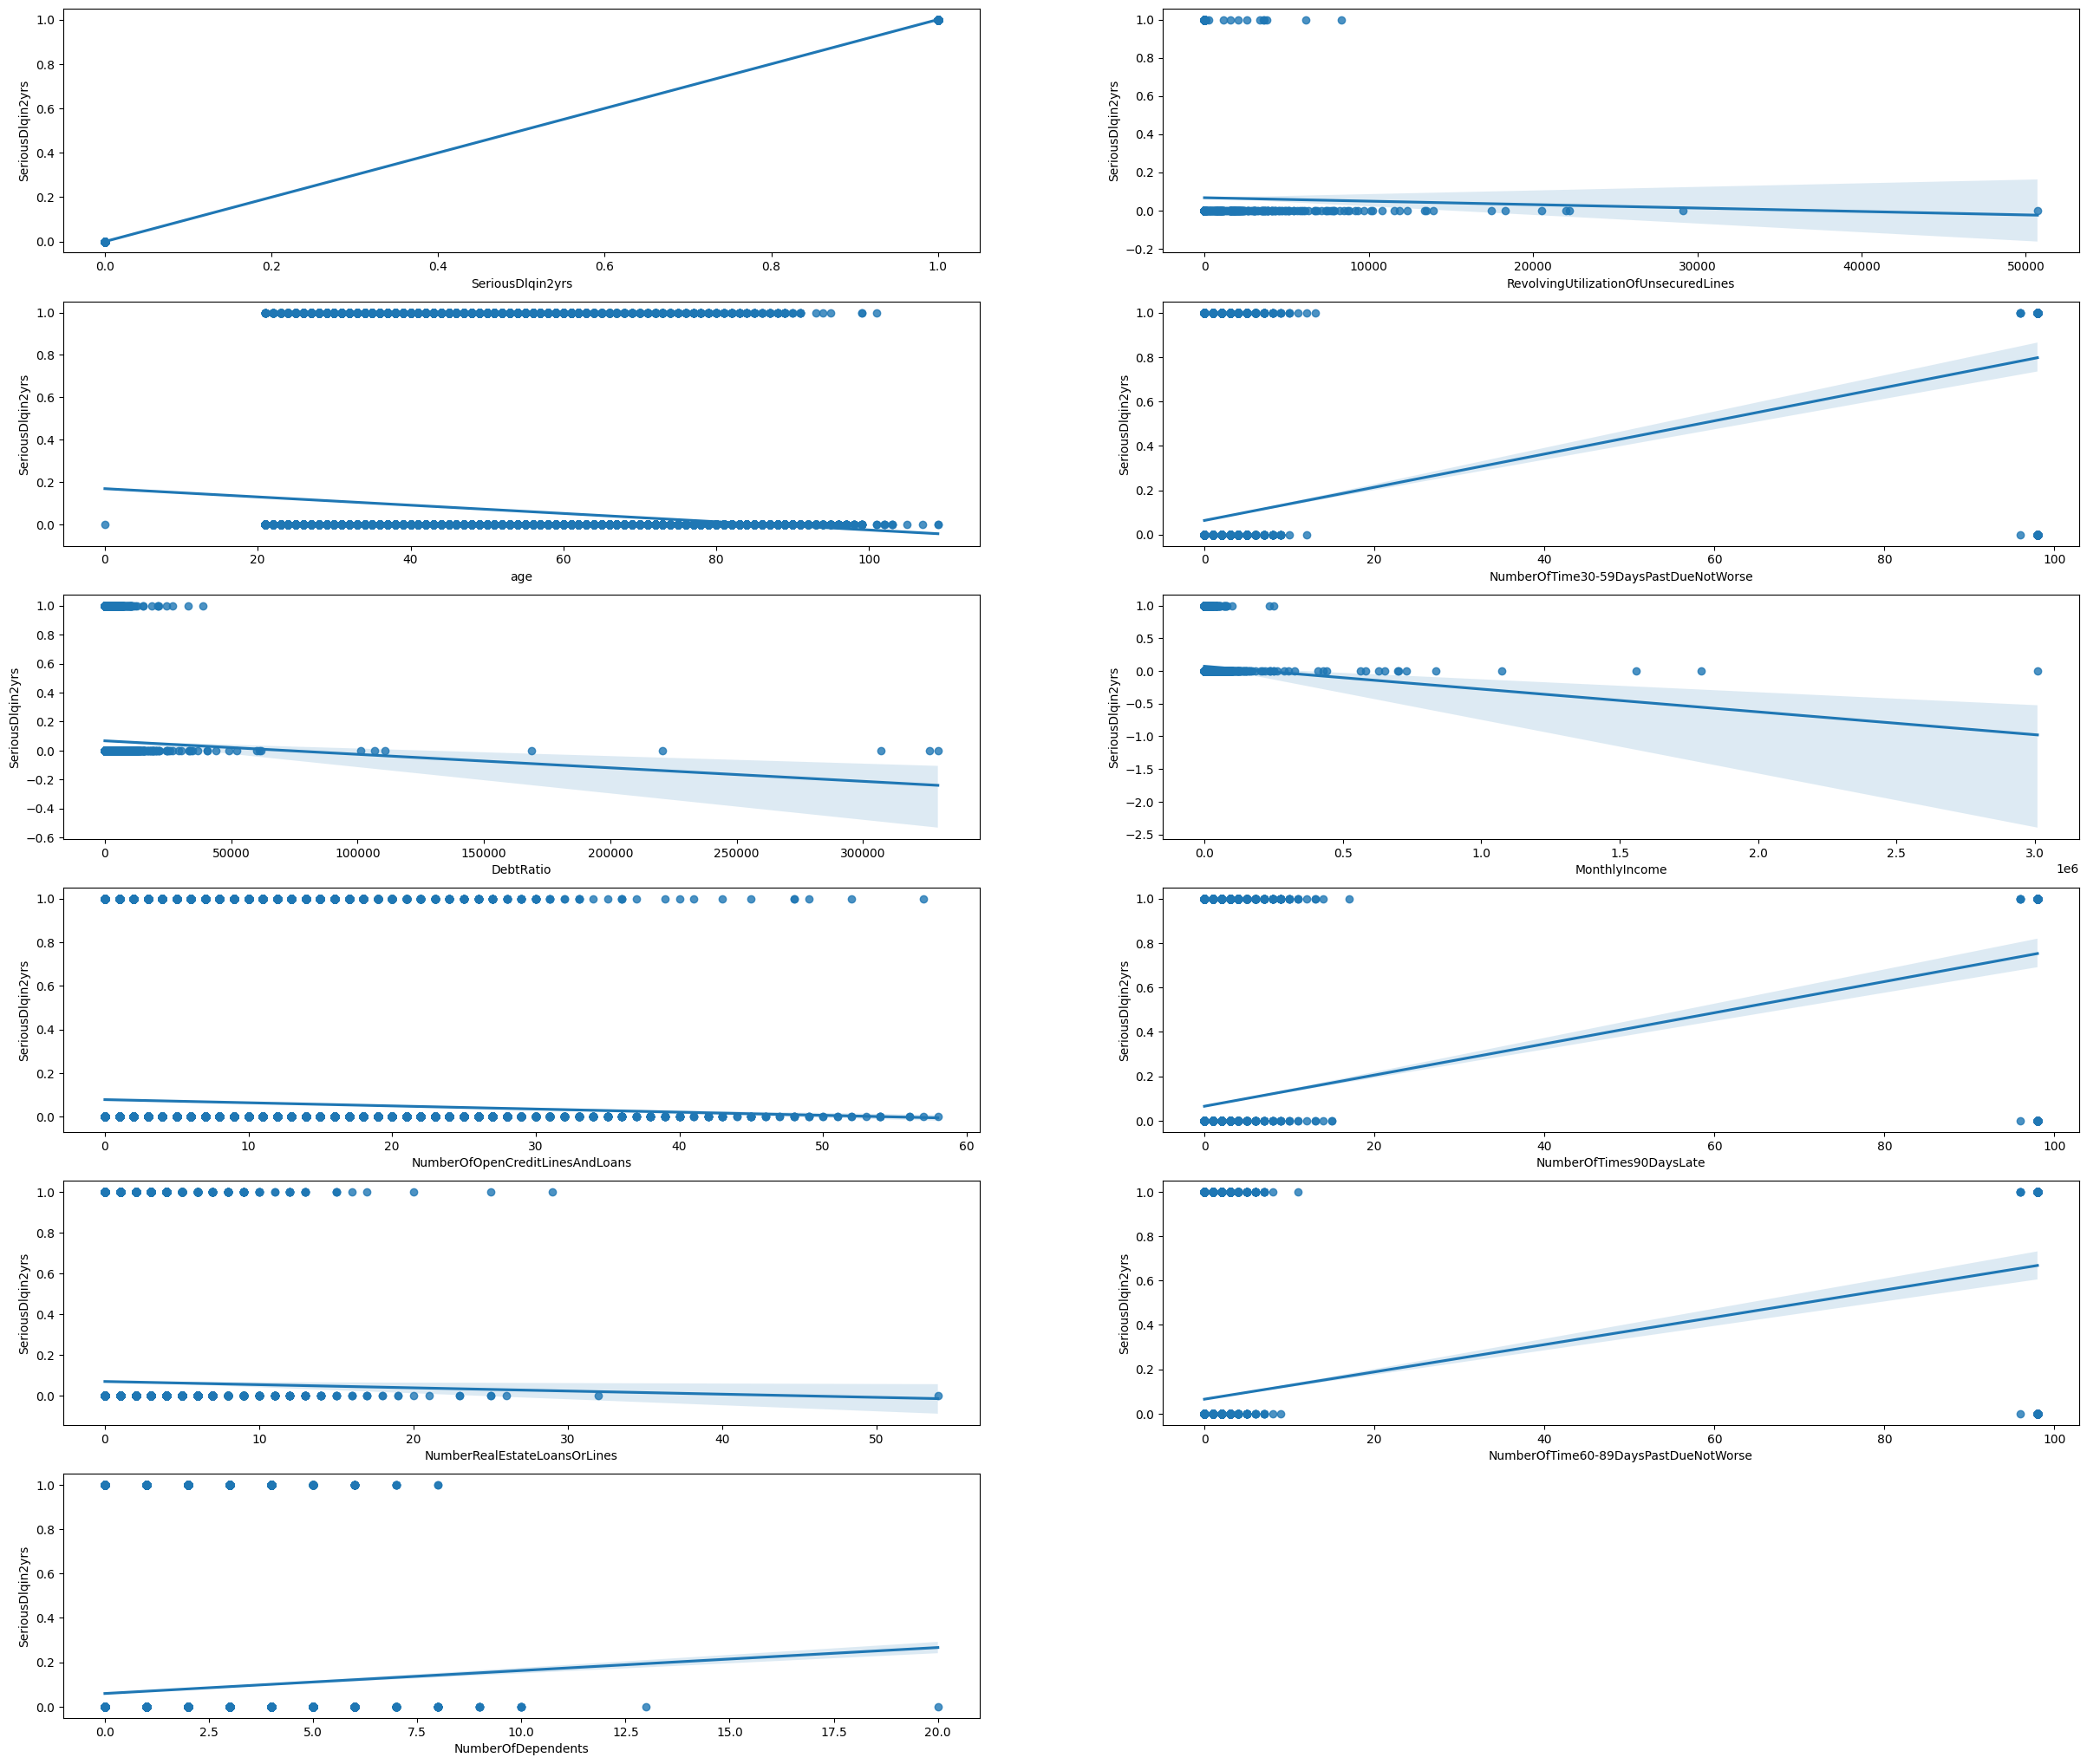

In [10]:
fig = plt.figure(figsize=[30,30])
for col,i in zip(df_train.columns,range(1,13)):
    axes = fig.add_subplot(7,2,i)
    sns.regplot(data=df_train,x=df_train[col], y = df_train.SeriousDlqin2yrs,ax=axes)
plt.show()

Слишком большие значения в DebtRatio и RevolvingUtilizationOfUnsecuredLines, что не есть хорошо, нужно разобраться в чём дело.

В столбцах, где указана информация по просрочке есть непонятные выбросы, которые нарушают логику.

In [11]:
print("Значения больше 90 в столбце '30-59 Days' :",np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Значения больше 90 в столбце '60-89 Days' с учетом столбца '30-59 Days':",np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))

print("Уникальные значения в столбце NumberOfTime30-59DaysPastDueNotWorse",np.unique(df_train['NumberOfTime30-59DaysPastDueNotWorse']))
print("Максимальное значение в столбце '60-89 Days' когда в столбце '30-59 Days' значения меньше 90:",np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime60-89DaysPastDueNotWorse']).max())


print("Максимальное значение в столбце '90 Days' когда в столбце '30-59 Days' значения меньше 90:",np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                        ['NumberOfTimes90DaysLate']).max())

Значения больше 90 в столбце '30-59 Days' : [96 98]
Значения больше 90 в столбце '60-89 Days' с учетом столбца '30-59 Days': [96 98]
Уникальные значения в столбце NumberOfTime30-59DaysPastDueNotWorse [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 96 98]
Максимальное значение в столбце '60-89 Days' когда в столбце '30-59 Days' значения меньше 90: 11
Максимальное значение в столбце '90 Days' когда в столбце '30-59 Days' значения меньше 90: 17


Заменим их на максимальные значения перед ними, которые попадают в диапазон

In [12]:
df_train.loc[df_train['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
df_train.loc[df_train['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
df_train.loc[df_train['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17

Разбираемся с c двумя другими проблемными столбцами.

In [13]:
df_train[['DebtRatio',"RevolvingUtilizationOfUnsecuredLines"]].describe()


,DebtRatio,RevolvingUtilizationOfUnsecuredLines
count,150000.000000,150000.000000
mean,353.005076,6.048438
std,2037.818523,249.755371
min,0.000000,0.000000
25%,0.175074,0.029867
50%,0.366508,0.154181
75%,0.868254,0.559046
max,329664.000000,50708.000000


Между 75 квантилем и максимальным значением огромная разница. Так как датасет большой, то логично посмотреть значения выше 95 квантиля.

In [14]:
df_train[df_train['DebtRatio'] >= df_train['DebtRatio'].quantile(0.95)][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,7501.000000,379.000000
mean,0.055193,0.084433
std,0.228371,0.278403
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Значения в графе MonthlyIncome выглядят ошибочными, 1 и 0 максимальное настораживает.

In [15]:
df_train[(df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)) & (df_train['SeriousDlqin2yrs'] == df_train['MonthlyIncome'])][['SeriousDlqin2yrs', 'MonthlyIncome'	]]

,SeriousDlqin2yrs,MonthlyIncome
50,0,0.0
73,0,0.0
90,0,0.0
326,0,0.0
508,0,0.0
...,...,...
147523,0,0.0
148258,0,0.0
148432,0,0.0
149383,0,0.0


Так и вышло. В этих строках значения обоих столбцов совпадают, а это что ни на есть - ошибка ввода данных, поэтому убираем их.

In [16]:
df_train = df_train[-((df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)) & (df_train['SeriousDlqin2yrs'] == df_train['MonthlyIncome']))]
df_train

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [17]:
df_train[df_train['RevolvingUtilizationOfUnsecuredLines']>13].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,238.000000,238.000000,238.000000,238.000000,238.000000,170.000000,238.000000,238.000000,238.000000,238.000000,225.000000
mean,0.058824,3608.797826,50.634454,0.163866,579.117900,8520.041176,5.689076,0.071429,1.176471,0.071429,0.693333
std,0.235790,5140.423232,14.617658,0.522123,1782.962163,6606.889618,3.032170,0.580214,1.064558,0.542637,1.043346
min,0.000000,14.000000,24.000000,0.000000,0.000800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,951.000000,39.000000,0.000000,0.216587,4608.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2023.500000,48.000000,0.000000,0.391176,7000.000000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4128.750000,62.000000,0.000000,82.250000,10178.750000,7.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,87.000000,3.000000,21395.000000,44472.000000,21.000000,8.000000,9.000000,7.000000,4.000000


In [18]:
df_train = df_train[df_train['RevolvingUtilizationOfUnsecuredLines']<=13]

In [19]:
df_train['MonthlyIncome'].fillna(df_train['MonthlyIncome'].median(), inplace=True)
df_train['NumberOfDependents'].fillna(0, inplace = True)

<ipython-input-19-ee953fc17a28>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['MonthlyIncome'].fillna(df_train['MonthlyIncome'].median(), inplace=True)
<ipython-input-19-ee953fc17a28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['NumberOfDependents'].fillna(0, inplace = True)


Text(0.5, 1.0, 'Correlation Matrix')

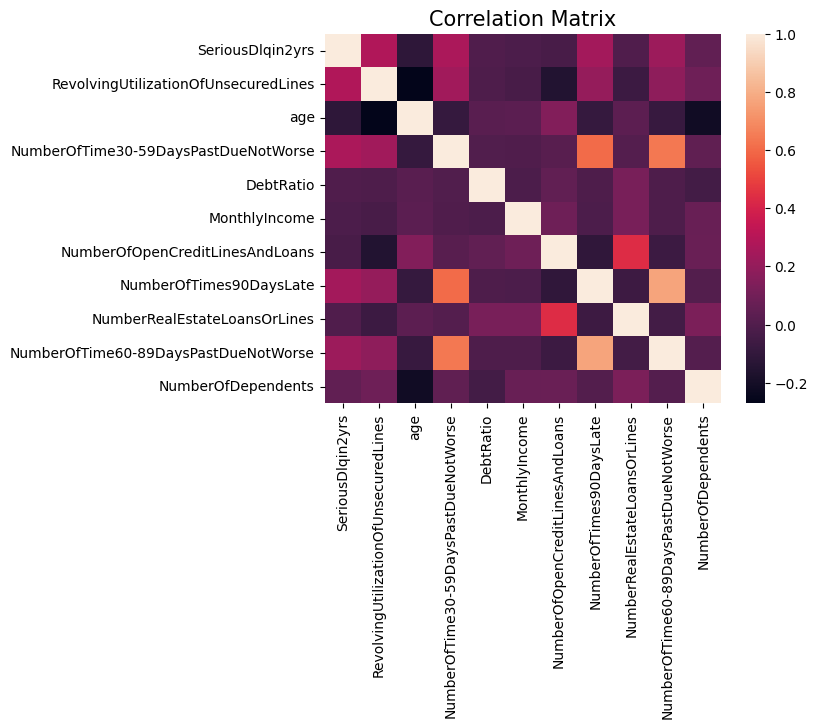

In [20]:
sns.heatmap(df_train.corr())
plt.title("Correlation Matrix", fontsize = 15)

In [21]:
df_train["age"].describe()

count    149431.000000
mean         52.302541
std          14.778775
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

<Axes: xlabel='age', ylabel='Count'>

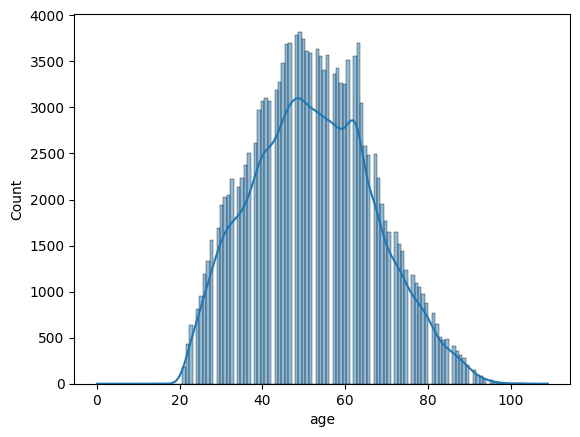

In [22]:
sns.histplot(df_train["age"], kde=True)

<Axes: xlabel='age', ylabel='Count'>

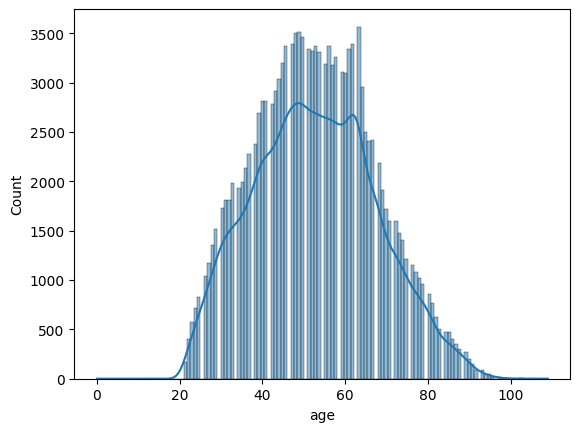

In [23]:
sns.histplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 0]["age"], kde=True)

<Axes: xlabel='age', ylabel='Count'>

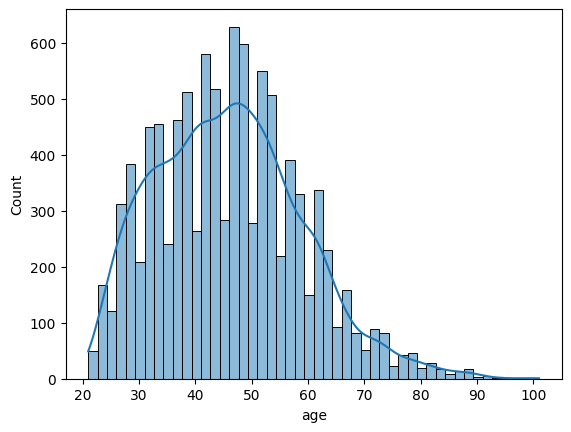

In [24]:
sns.histplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 1]["age"], kde=True)

<Axes: xlabel='NumberOfDependents', ylabel='count'>

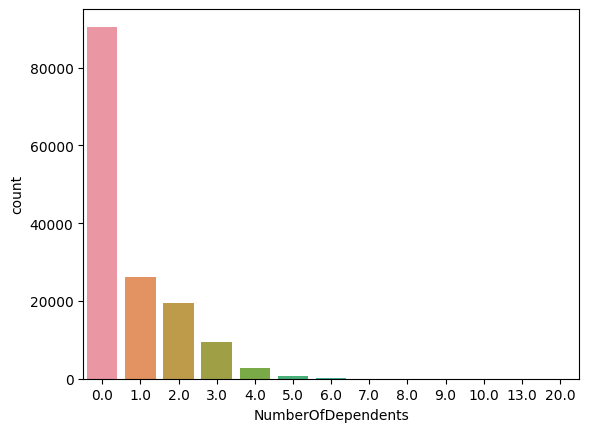

In [25]:
sns.countplot(x='NumberOfDependents',data=df_train)

In [26]:
X = df_train.drop('SeriousDlqin2yrs', axis=1)
y = df_train['SeriousDlqin2yrs']
X.shape,y.shape

((149431, 10), (149431,))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

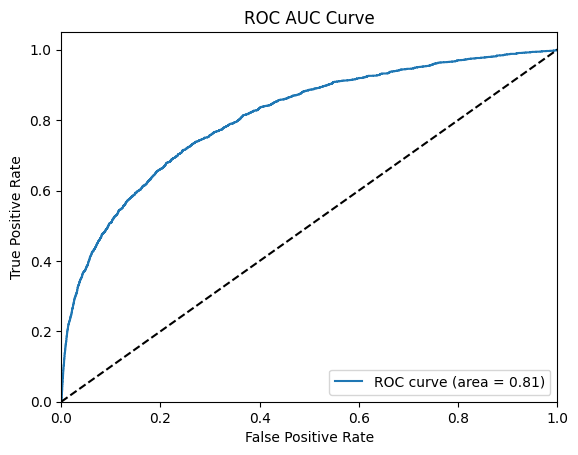

ROC AUC: 0.8081219992433213
Precision: 0.5837988826815642
Recall: 0.10690537084398977
Accuracy: 0.9365945059724964


In [29]:
y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, )
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

# вывод метрик на экран
print('ROC AUC:', roc_auc)
print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)

Accuracy показывает прекрасный результат, roc auc - хороший, а вот Precision и Recall - плохой. Модель испытывает большие проблемы с классифицирование положительного результат. Скорее всего это связано с тем, что данные не сбалансированы, количество объектов относящихся к положительному классу в таргет переменной меньше 7%. 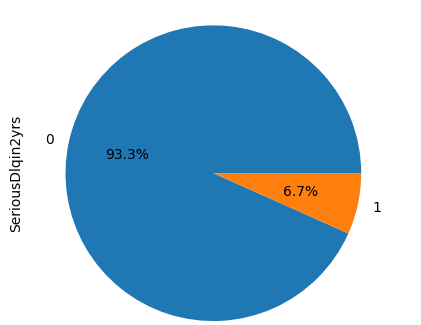

In [30]:
f1_score(y_test,y_pred) #на всякий случай проверили предположение с помощью f1.

0.18071768266320795

In [31]:
scaler = MinMaxScaler()
df_train['MonthlyIncome'] = scaler.fit_transform(df_train['MonthlyIncome'].values.reshape(-1,1))

df_train['NumberOfOpenCreditLinesAndLoans'] = scaler.fit_transform(df_train['NumberOfOpenCreditLinesAndLoans'].values.reshape(-1,1))
df_train['NumberRealEstateLoansOrLines'] = scaler.fit_transform(df_train['NumberRealEstateLoansOrLines'].values.reshape(-1,1))
df_train['DebtRatio'] = scaler.fit_transform(df_train['DebtRatio'].values.reshape(-1,1))
df_train['NumberOfDependents'] = scaler.fit_transform(df_train['NumberOfDependents'].values.reshape(-1,1))
df_train['age'] = scaler.fit_transform(df_train['age'].values.reshape(-1,1))

<ipython-input-31-eb35294557fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['MonthlyIncome'] = scaler.fit_transform(df_train['MonthlyIncome'].values.reshape(-1,1))
<ipython-input-31-eb35294557fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['NumberOfOpenCreditLinesAndLoans'] = scaler.fit_transform(df_train['NumberOfOpenCreditLinesAndLoans'].values.reshape(-1,1))
<ipython-input-31-eb35294557fc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [32]:
df_zero = df_train[df_train['SeriousDlqin2yrs']==0]
balanced_df = df_zero.sample(frac=0.1)
balanced_df = balanced_df[:10009]
balanced_df.shape

(10009, 11)

In [33]:
positives = df_train[df_train['SeriousDlqin2yrs']==1]
balanced_df = balanced_df.append(positives)
balanced_df.shape

<ipython-input-33-19b6a77a71e0>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(positives)


(20018, 11)

In [34]:
balanced_df['SeriousDlqin2yrs'].value_counts()

0    10009
1    10009
Name: SeriousDlqin2yrs, dtype: int64

In [35]:
X = balanced_df.drop('SeriousDlqin2yrs', axis=1)
y = balanced_df['SeriousDlqin2yrs']
X.shape,y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

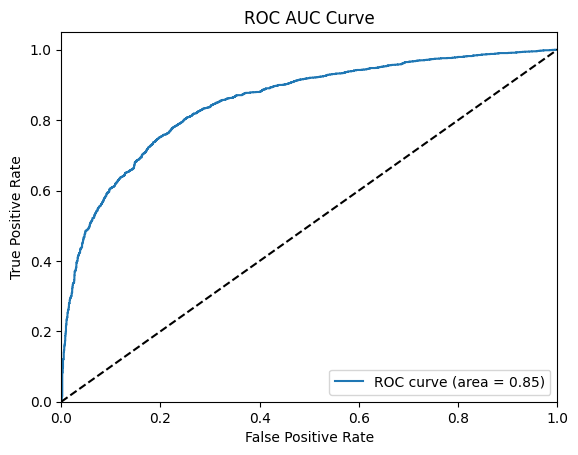

ROC AUC: 0.851792355030383
Precision: 0.7941333333333334
Recall: 0.7448724362181091
Accuracy: 0.7762237762237763


In [37]:
y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, )
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

# вывод метрик на экран
print('ROC AUC:', roc_auc)
print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)

Ситуация сразу стала резко лучше, а метрика accuracy перестала нас обманывать. Теперь можно попробовать другие модели и перейти к глубокому обучению.

In [38]:
!pip install catboost
from catboost import CatBoostClassifier, Pool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
test_data = catboost_pool = Pool(X_train, y_train)
model = CatBoostClassifier(iterations=100,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)

In [40]:
model.fit(X_train, y_train)
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.5401793	total: 48.6ms	remaining: 4.81s
1:	learn: 0.4917173	total: 50.6ms	remaining: 2.48s
2:	learn: 0.4849258	total: 52.5ms	remaining: 1.7s
3:	learn: 0.4810803	total: 54.5ms	remaining: 1.31s
4:	learn: 0.4764644	total: 56.5ms	remaining: 1.07s
5:	learn: 0.4735097	total: 58.6ms	remaining: 918ms
6:	learn: 0.4696075	total: 60.5ms	remaining: 804ms
7:	learn: 0.4668508	total: 62.4ms	remaining: 717ms
8:	learn: 0.4656722	total: 64.3ms	remaining: 650ms
9:	learn: 0.4646528	total: 66.2ms	remaining: 596ms
10:	learn: 0.4631565	total: 68.5ms	remaining: 555ms
11:	learn: 0.4617841	total: 71.3ms	remaining: 523ms
12:	learn: 0.4610996	total: 74.6ms	remaining: 499ms
13:	learn: 0.4603938	total: 77.5ms	remaining: 476ms
14:	learn: 0.4592440	total: 79.4ms	remaining: 450ms
15:	learn: 0.4582239	total: 81.2ms	remaining: 426ms
16:	learn: 0.4576882	total: 83ms	remaining: 405ms
17:	learn: 0.4570888	total: 84.8ms	remaining: 386ms
18:	learn: 0.4559687	total: 86.8ms	remaining: 370ms
19:	learn: 0.4553718	tota

In [41]:

precision = precision_score(y_test, preds_class)
recall = recall_score(y_test, preds_class)
accuracy = accuracy_score(y_test, preds_class)

# вывод метрик на экран

print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)

Precision: 0.8045738045738046
Recall: 0.7743871935967984
Accuracy: 0.7934565434565435


Как видим, результаты стали немного лучше. При этом, мы толком не настраивали гиперпараметры модели, если правильно их обработать - результат будет сильно лучше. Делать этого нет смысла, так как основными моделями в работе являются модели глубокого обучения, поэтому перейдём сразу к ним. Логистическая регрессия и кэтбуст показали, что датасет в порядке и теперь можно заниматься созданием и настройкой нейросетей.

In [42]:
y_train=np.vstack(y_train.values).astype(np.float64)
y_test=np.vstack(y_test.values).astype(np.float64)


X_train, y_train, X_test, y_test = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32), torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [43]:
batch_size = 50

train_dl = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size)

test_dl = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [44]:
model = nn.Sequential(
    nn.Linear(10,60),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(60,30),
    nn.Sigmoid(),
    nn.Dropout(p=0.2),
    nn.Linear(30,15),
    nn.Tanh(),
    nn.Dropout(p=0.2),
    nn.Linear(15,15),
    nn.Tanh(),
    nn.Dropout(p=0.2),
    nn.Linear(15,2),
    nn.Sigmoid()
)

In [46]:
%%time
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.ASGD(model.parameters(), lr=0.01, weight_decay=0.01)

# Обучение модели
for epoch in range(50):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs)
        loss = criterion(outputs.squeeze(), labels.squeeze().long())
        l1_reg = torch.tensor(0.)
        for param in model.parameters():
          l1_reg += torch.norm(param, 1)
        loss += 0.001 * l1_reg
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_dl)))

Epoch 1 loss: 0.983
Epoch 2 loss: 0.963
Epoch 3 loss: 0.945
Epoch 4 loss: 0.927
Epoch 5 loss: 0.910
Epoch 6 loss: 0.894
Epoch 7 loss: 0.879
Epoch 8 loss: 0.864
Epoch 9 loss: 0.850
Epoch 10 loss: 0.837
Epoch 11 loss: 0.825
Epoch 12 loss: 0.813
Epoch 13 loss: 0.802
Epoch 14 loss: 0.792
Epoch 15 loss: 0.782
Epoch 16 loss: 0.773
Epoch 17 loss: 0.764
Epoch 18 loss: 0.757
Epoch 19 loss: 0.749
Epoch 20 loss: 0.743
Epoch 21 loss: 0.736
Epoch 22 loss: 0.731
Epoch 23 loss: 0.726
Epoch 24 loss: 0.722
Epoch 25 loss: 0.718
Epoch 26 loss: 0.715
Epoch 27 loss: 0.712
Epoch 28 loss: 0.709
Epoch 29 loss: 0.707
Epoch 30 loss: 0.705
Epoch 31 loss: 0.703
Epoch 32 loss: 0.702
Epoch 33 loss: 0.700
Epoch 34 loss: 0.699
Epoch 35 loss: 0.698
Epoch 36 loss: 0.697
Epoch 37 loss: 0.696
Epoch 38 loss: 0.695
Epoch 39 loss: 0.695
Epoch 40 loss: 0.694
Epoch 41 loss: 0.694
Epoch 42 loss: 0.693
Epoch 43 loss: 0.693
Epoch 44 loss: 0.693
Epoch 45 loss: 0.693
Epoch 46 loss: 0.693
Epoch 47 loss: 0.693
Epoch 48 loss: 0.693
E

In [47]:
correct = 0
total = 0
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_dl:
        outputs = model(inputs)
        #print(outputs)
        predicted = outputs.argmax(-1)
        #print(predicted.shape, labels.shape)
        #print(predicted)
        total += labels.size(0)
        #print(labels.size(0))
        correct += (predicted == labels.squeeze()).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
        #print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))

print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))
#print(y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('ROC-AUC: %.3f' % roc_auc)

Accuracy of the network on the test set: 49 %
Recall: 1.000
Precision: 0.499
ROC-AUC: 0.500


In [48]:
confusion_matrix(y_true, y_pred)


array([[   0, 2005],
       [   0, 1999]])

In [49]:
model = nn.Sequential(
    nn.Linear(10,60),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(60,30),
    nn.Sigmoid(),
    nn.Dropout(p=0.2),
    nn.Linear(30,15),
    nn.Tanh(),
    nn.Dropout(p=0.2),
    nn.Linear(15,10),
    nn.Tanh(),
    nn.Dropout(p=0.2),
    nn.Linear(10,5),
    nn.Sigmoid(),
    nn.Dropout(p=0.2),
    nn.Linear(5,1),
    nn.Sigmoid()
)

In [50]:
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Обучение модели
for epoch in range(30):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        l1_reg = torch.tensor(0.)
        for param in model.parameters():
          l1_reg += torch.norm(param, 1)
        loss += 0.002 * l1_reg
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_dl)))

Epoch 1 loss: 0.841
Epoch 2 loss: 0.700
Epoch 3 loss: 0.698
Epoch 4 loss: 0.697
Epoch 5 loss: 0.696
Epoch 6 loss: 0.695
Epoch 7 loss: 0.695
Epoch 8 loss: 0.695
Epoch 9 loss: 0.694
Epoch 10 loss: 0.694
Epoch 11 loss: 0.694
Epoch 12 loss: 0.694
Epoch 13 loss: 0.694
Epoch 14 loss: 0.694
Epoch 15 loss: 0.694
Epoch 16 loss: 0.694
Epoch 17 loss: 0.694
Epoch 18 loss: 0.694
Epoch 19 loss: 0.694
Epoch 20 loss: 0.694
Epoch 21 loss: 0.694
Epoch 22 loss: 0.694
Epoch 23 loss: 0.694
Epoch 24 loss: 0.694
Epoch 25 loss: 0.694
Epoch 26 loss: 0.694
Epoch 27 loss: 0.694
Epoch 28 loss: 0.694
Epoch 29 loss: 0.694
Epoch 30 loss: 0.694


In [51]:
correct = 0
total = 0
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_dl:
        outputs = model(inputs)
        #print(outputs)
        predicted = outputs.argmax(-1)
        #print(predicted.shape, labels.shape)
        #print(predicted)
        total += labels.size(0)
        #print(labels.size(0))
        correct += (predicted == labels.squeeze()).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
        #print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))

print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))
#print(y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('ROC-AUC: %.3f' % roc_auc)

Accuracy of the network on the test set: 50 %
Recall: 0.000
Precision: 0.000
ROC-AUC: 0.500


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
confusion_matrix(y_true, y_pred)

array([[2005,    0],
       [1999,    0]])

In [53]:
class Net(nn.Module):
    def __init__(self, n_inputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 16)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(16, 32)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.tanh(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

model = Net(10)
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters())
y_true, y_pred = [], []
for epoch in range(100):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_dl)))

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dl:
        outputs = model(inputs)
        predicted = (outputs > 0.6).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

print('Accuracy on test set: %.2f %%' % (100 * correct / total))

Epoch 1 loss: 0.511
Epoch 2 loss: 0.497
Epoch 3 loss: 0.494
Epoch 4 loss: 0.495
Epoch 5 loss: 0.493
Epoch 6 loss: 0.491
Epoch 7 loss: 0.492
Epoch 8 loss: 0.491
Epoch 9 loss: 0.495
Epoch 10 loss: 0.493
Epoch 11 loss: 0.489
Epoch 12 loss: 0.488
Epoch 13 loss: 0.489
Epoch 14 loss: 0.490
Epoch 15 loss: 0.490
Epoch 16 loss: 0.489
Epoch 17 loss: 0.486
Epoch 18 loss: 0.488
Epoch 19 loss: 0.486
Epoch 20 loss: 0.487
Epoch 21 loss: 0.489
Epoch 22 loss: 0.486
Epoch 23 loss: 0.486
Epoch 24 loss: 0.488
Epoch 25 loss: 0.489
Epoch 26 loss: 0.488
Epoch 27 loss: 0.490
Epoch 28 loss: 0.489
Epoch 29 loss: 0.490
Epoch 30 loss: 0.486
Epoch 31 loss: 0.488
Epoch 32 loss: 0.490
Epoch 33 loss: 0.487
Epoch 34 loss: 0.488
Epoch 35 loss: 0.486
Epoch 36 loss: 0.486
Epoch 37 loss: 0.488
Epoch 38 loss: 0.490
Epoch 39 loss: 0.489
Epoch 40 loss: 0.487
Epoch 41 loss: 0.488
Epoch 42 loss: 0.490
Epoch 43 loss: 0.486
Epoch 44 loss: 0.489
Epoch 45 loss: 0.489
Epoch 46 loss: 0.489
Epoch 47 loss: 0.487
Epoch 48 loss: 0.488
E

In [54]:
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('ROC-AUC: %.3f' % roc_auc)
confusion_matrix(y_true, y_pred)

Recall: 0.654
Precision: 0.843
ROC-AUC: 0.766


array([[1761,  244],
       [ 691, 1308]])

In [55]:
class Net(nn.Module):
    def __init__(self, n_inputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 16)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(16, 32)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc4 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.tanh(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        x = self.dropout1(x)
        x = self.sigmoid(self.fc4(x))
        return x

model = Net(10)
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters())
y_true, y_pred = [], []
for epoch in range(40):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_dl)))

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dl: 
        outputs = model(inputs)
        predicted = (outputs > 0.55).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

print('Accuracy on test set: %.2f %%' % (100 * correct / total))

Epoch 1 loss: 0.539
Epoch 2 loss: 0.518
Epoch 3 loss: 0.522
Epoch 4 loss: 0.519
Epoch 5 loss: 0.517
Epoch 6 loss: 0.515
Epoch 7 loss: 0.519
Epoch 8 loss: 0.515
Epoch 9 loss: 0.510
Epoch 10 loss: 0.518
Epoch 11 loss: 0.514
Epoch 12 loss: 0.516
Epoch 13 loss: 0.515
Epoch 14 loss: 0.514
Epoch 15 loss: 0.515
Epoch 16 loss: 0.517
Epoch 17 loss: 0.519
Epoch 18 loss: 0.516
Epoch 19 loss: 0.510
Epoch 20 loss: 0.515
Epoch 21 loss: 0.516
Epoch 22 loss: 0.515
Epoch 23 loss: 0.512
Epoch 24 loss: 0.513
Epoch 25 loss: 0.514
Epoch 26 loss: 0.514
Epoch 27 loss: 0.515
Epoch 28 loss: 0.519
Epoch 29 loss: 0.515
Epoch 30 loss: 0.514
Epoch 31 loss: 0.516
Epoch 32 loss: 0.516
Epoch 33 loss: 0.513
Epoch 34 loss: 0.519
Epoch 35 loss: 0.518
Epoch 36 loss: 0.517
Epoch 37 loss: 0.520
Epoch 38 loss: 0.516
Epoch 39 loss: 0.517
Epoch 40 loss: 0.518
Accuracy on test set: 74.13 %


In [56]:
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('ROC-AUC: %.3f' % roc_auc)
confusion_matrix(y_true, y_pred)

Recall: 0.567
Precision: 0.869
ROC-AUC: 0.741


array([[1834,  171],
       [ 865, 1134]])

In [75]:
class Net(nn.Module):
    def __init__(self, feature_count, hidden_layer_size=1024, drop_out=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(feature_count, hidden_layer_size)
        self.leakyrelu1 = nn.LeakyReLU(negative_slope=0.2)
        self.dropout1 = nn.Dropout(p=drop_out)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.leakyrelu2 = nn.LeakyReLU(negative_slope=0.2)
        self.dropout2 = nn.Dropout(p=drop_out)
        self.fc3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.leakyrelu3 = nn.LeakyReLU(negative_slope=0.2)
        self.dropout3 = nn.Dropout(p=drop_out)
        self.fc4 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.leakyrelu4 = nn.LeakyReLU(negative_slope=0.2)
        self.fc5 = nn.Linear(hidden_layer_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leakyrelu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.leakyrelu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.leakyrelu3(self.fc3(x))
        x = self.dropout3(x)
        x = self.leakyrelu4(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

model = Net(10, hidden_layer_size=1024, drop_out=0.2)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
y_true, y_pred = [], []

for epoch in range(30):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dl):  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_dl)))

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dl:
        outputs = model(inputs)
        predicted = (outputs > 0.51).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

print('Accuracy on test set: %.2f %%' % (100 * correct / total))

Epoch 1 loss: 0.524
Epoch 2 loss: 0.492
Epoch 3 loss: 0.487
Epoch 4 loss: 0.480
Epoch 5 loss: 0.477
Epoch 6 loss: 0.476
Epoch 7 loss: 0.487
Epoch 8 loss: 0.507
Epoch 9 loss: 0.474
Epoch 10 loss: 0.473
Epoch 11 loss: 0.475
Epoch 12 loss: 0.476
Epoch 13 loss: 0.472
Epoch 14 loss: 0.472
Epoch 15 loss: 0.469
Epoch 16 loss: 0.469
Epoch 17 loss: 0.470
Epoch 18 loss: 0.469
Epoch 19 loss: 0.469
Epoch 20 loss: 0.473
Epoch 21 loss: 0.471
Epoch 22 loss: 0.469
Epoch 23 loss: 0.471
Epoch 24 loss: 0.469
Epoch 25 loss: 0.468
Epoch 26 loss: 0.467
Epoch 27 loss: 0.468
Epoch 28 loss: 0.468
Epoch 29 loss: 0.469
Epoch 30 loss: 0.469
Accuracy on test set: 78.07 %


In [76]:
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('ROC-AUC: %.3f' % roc_auc)
confusion_matrix(y_true, y_pred)

Recall: 0.773
Precision: 0.785
ROC-AUC: 0.781


array([[1581,  424],
       [ 454, 1545]])